In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
import xgboost as xgb
import math

%matplotlib inline

In [1132]:
train_df = pd.read_csv('data/cs-training.csv', index_col=0)

In [1077]:
#train_df = train_df.drop_duplicates()

In [1078]:
train_df=train_df.rename(columns={'NumberOfTime30-59DaysPastDueNotWorse':'NumberOfTime30_59DaysPastDueNotWorse', 
                                  'NumberOfTime60-89DaysPastDueNotWorse':'NumberOfTime60_89DaysPastDueNotWorse'})

In [1079]:
train_df=train_df.fillna(value={'MonthlyIncome':train_df.MonthlyIncome.mean(), 
                                'NumberOfDependents':train_df.NumberOfDependents.mean()})

In [1080]:
train_df['MonthlyIncome']=train_df.MonthlyIncome.apply(lambda x: math.log1p(x))
train_df['DebtRatio']=train_df.DebtRatio.apply(lambda x: math.log1p(x))
train_df['RevolvingUtilizationOfUnsecuredLines']=train_df.RevolvingUtilizationOfUnsecuredLines.apply(lambda x: math.log1p(x))

In [1081]:
train_df['NumberOfTimesDaysLate']=101*train_df['NumberOfTimes90DaysLate'] + \
                                  51*train_df['NumberOfTime60_89DaysPastDueNotWorse'] + \
                                  23*train_df['NumberOfTime30_59DaysPastDueNotWorse']
#train_df['NumberOfTimesDaysLate']=train_df.NumberOfTimesDaysLate.apply(lambda x: math.log1p(x))

In [1082]:
train_df=train_df.drop(['NumberOfTimes90DaysLate',
                        'NumberOfTime60_89DaysPastDueNotWorse',
                        'NumberOfTime30_59DaysPastDueNotWorse'], axis=1)

In [1083]:
train_df=train_df[train_df.age > 0]

In [1084]:
y_train_df = train_df.SeriousDlqin2yrs
X_train_df = train_df.drop('SeriousDlqin2yrs', axis=1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11be3f240>]], dtype=object)

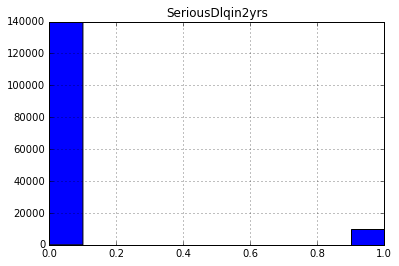

In [1085]:
train_df.hist(column=['SeriousDlqin2yrs'])

In [1086]:
random_state=42

In [1087]:
x_train, x_rest, y_train, y_rest = train_test_split(X_train_df, y_train_df, 
                                                    test_size=0.2, 
                                                    random_state=random_state, 
                                                    stratify=y_train_df)

In [1088]:
train_mat = xgb.DMatrix(x_train, y_train)

In [1089]:
params = {'eta':0.1, 'seed':random_state, 'subsample':0.8,
          'colsample_bytree':0.8, 'objective': 'binary:logistic', 
          'max_depth':3, 'min_child_weight':1}

In [1111]:
gbm_cv = xgb.cv(params=params, dtrain=train_mat, stratified=True,
                num_boost_round=3000, nfold=5, 
                metrics=['auc'], early_stopping_rounds=100)

In [1112]:
gbm_cv.tail(5)

,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std
192,0.865063,0.003101,0.875113,0.000618
193,0.865092,0.003125,0.875198,0.000610
194,0.865078,0.003127,0.875243,0.000606
195,0.865100,0.003135,0.875281,0.000604
196,0.865111,0.003149,0.875332,0.000599


In [1113]:
final_gbm = xgb.train(params, train_mat, num_boost_round=200) 

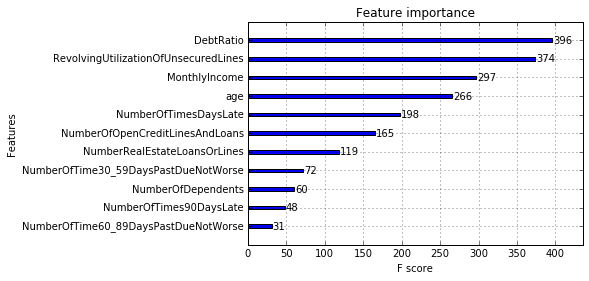

In [1114]:
xgb.plot_importance(final_gbm)

In [1115]:
test_mat = xgb.DMatrix(x_rest)

In [1116]:
y_preds = final_gbm.predict(test_mat)

In [1117]:
from sklearn import metrics

In [1118]:
metrics.roc_auc_score(y_rest,y_preds)

0.86974873051341994

In [1119]:
test_df = pd.read_csv('data/cs-test.csv',index_col=0)

In [1120]:
test_df=test_df.rename(columns={'NumberOfTime30-59DaysPastDueNotWorse':'NumberOfTime30_59DaysPastDueNotWorse', 
                                'NumberOfTime60-89DaysPastDueNotWorse':'NumberOfTime60_89DaysPastDueNotWorse'})

In [1121]:
test_df=test_df.fillna(value={'MonthlyIncome':test_df.MonthlyIncome.mean(), 
                              'NumberOfDependents':test_df.NumberOfDependents.mean()})

In [1122]:
test_df['MonthlyIncome']=test_df.MonthlyIncome.apply(lambda x: math.log1p(x))
test_df['DebtRatio']=test_df.DebtRatio.apply(lambda x: math.log1p(x))
test_df['RevolvingUtilizationOfUnsecuredLines']=test_df.RevolvingUtilizationOfUnsecuredLines.apply(lambda x: math.log1p(x))

In [1123]:
test_df['NumberOfTimesDaysLate']=101*test_df['NumberOfTimes90DaysLate'] + \
                                 51*test_df['NumberOfTime60_89DaysPastDueNotWorse'] + \
                                 23*test_df['NumberOfTime30_59DaysPastDueNotWorse']
#test_df['NumberOfTimesDaysLate']=test_df.NumberOfTimesDaysLate.apply(lambda x: math.log1p(x))

In [1124]:
test_df=test_df.drop(['NumberOfTimes90DaysLate',
                      'NumberOfTime60_89DaysPastDueNotWorse',
                      'NumberOfTime30_59DaysPastDueNotWorse'],axis=1)

In [1125]:
test_df = test_df.drop('SeriousDlqin2yrs', axis=1)

In [1126]:
ftest_mat = xgb.DMatrix(test_df)

In [1127]:
final_preds = final_gbm.predict(ftest_mat)

In [1128]:
final_preds

array([ 0.05976206,  0.05130825,  0.01303394, ...,  0.00497124,
        0.08816875,  0.04662374], dtype=float32)

In [1129]:
submit_df = pd.DataFrame(data={'Id':np.arange(1,len(final_preds)+1),'Probability':final_preds})

In [1130]:
submit_df.to_csv('data/submission.csv', index=False)